<a href="https://colab.research.google.com/github/fatihanadias/SatriaData2024/blob/main/FIX_VGG19_%2B_LSTM_%2B_SVM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T142109Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81074001c24f0b91b51d53c211ce119f66ff34c9e9631c06cad25e8bf41b8d66e4f64ce73c79854adc1a61131aba2d686b932fc34692d237d42e73a526c75dc71d57aade5cc40abe5577dba16301a2a897cd3f77f6f41fb85668d4b913147d5634a162364a3e94e1c85114e6ac7ffad3b3f1608a05fb79f120eeeecb714b3e5563fef8c04b464cab9c588e9239c0a37be707844d438099cd9a0047ad512bb63437e142c3e9b8a0cc776b4bd33a812938f7cfe23fd871c48dc7c7fb830dcafef2edf46343011b2330c89f45668f5f72c94a326bf384477bf95f13118d8d4126dadf23e27cb9c989b4ff321eaab941495c38957290301fe5e221bf49968053212d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Reshape, BatchNormalization, Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from math import floor

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, BatchNormalization

# Defining directories

In [ ]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Hyperparameters

In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224, 224]

# Data augmentation

In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224, 224),
                                                                shuffle=False)
# Mendapatkan nama kelas dari dataset train asli
class_names = train_data.class_names

def split_dataset(dataset, train_size=0.8, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_size * ds_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

# Membagi data train menjadi train dan validation
train_data, val_data = split_dataset(train_data)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
train_dataset_augmented = train_data.map(augment_image)

In [ ]:
import tensorflow as tf

# Menghitung jumlah data dalam setiap dataset
train_size = tf.data.experimental.cardinality(train_data).numpy()
val_size = tf.data.experimental.cardinality(val_data).numpy()
test_size = tf.data.experimental.cardinality(test_data).numpy()

# Menampilkan jumlah data
print(f"Number of samples in train dataset: {train_size}")
print(f"Number of samples in validation dataset: {val_size}")
print(f"Number of samples in test dataset: {test_size}")


Number of samples in train dataset: 143
Number of samples in validation dataset: 36
Number of samples in test dataset: 41


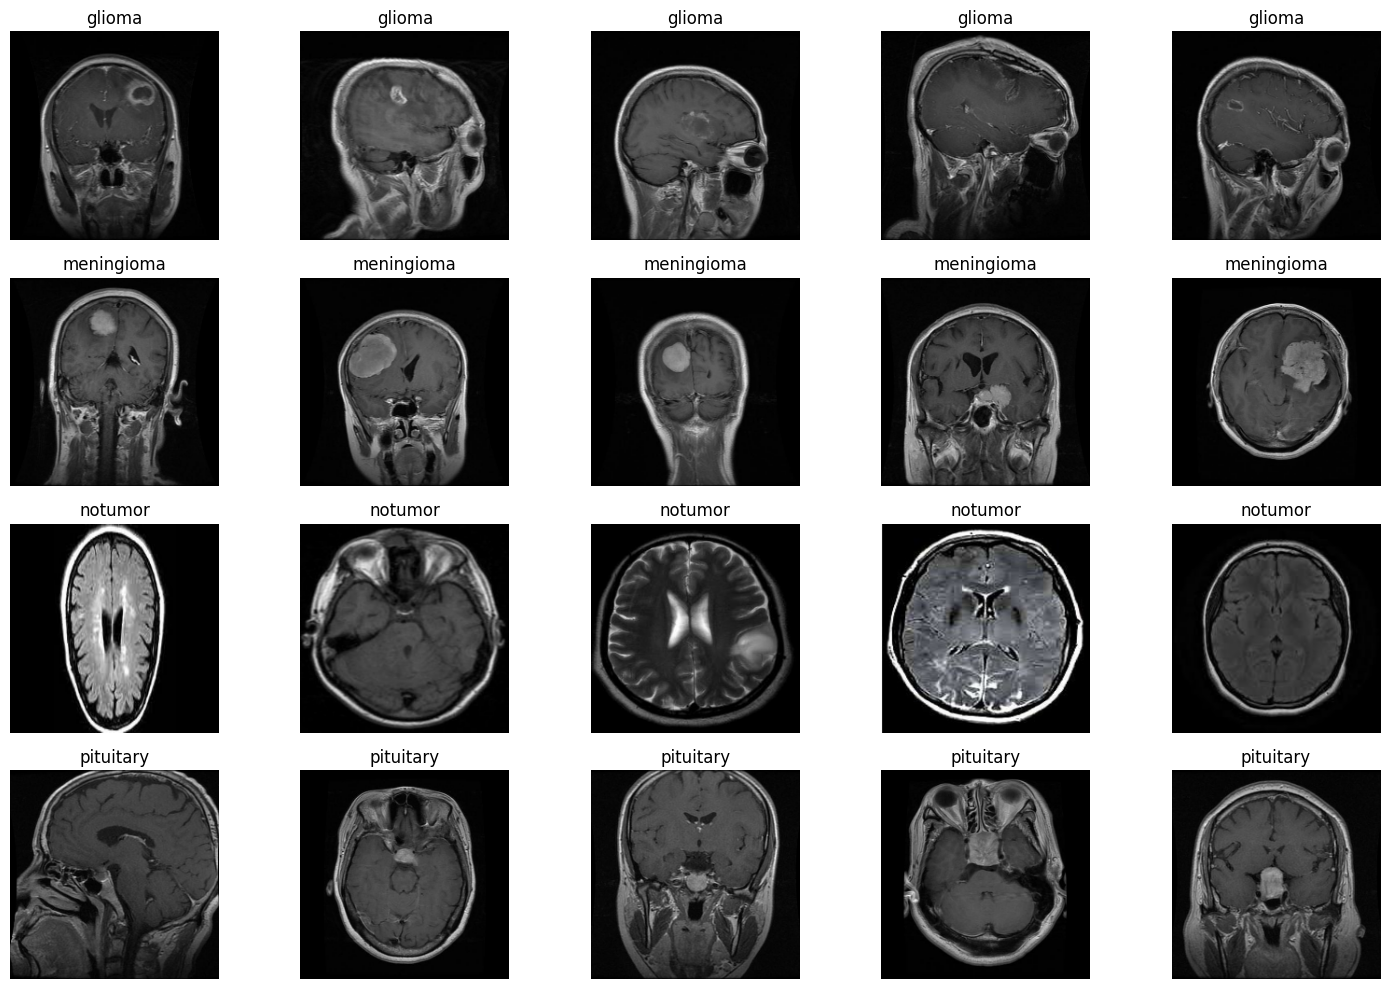

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Fungsi untuk membagi dataset train menjadi subset per kelas
def split_by_class(dataset, class_names):
    class_datasets = {class_name: [] for class_name in class_names}

    for images, labels in dataset:
        for i in range(len(images)):
            class_name = class_names[tf.argmax(labels[i])]
            class_datasets[class_name].append((images[i], labels[i]))

    return class_datasets

# Memanggil fungsi untuk membagi dataset train berdasarkan kelas
class_datasets = split_by_class(train_data, class_names)

# Menampilkan sampel dari masing-masing kelas
num_samples_per_class = 5  # Jumlah sampel yang ingin ditampilkan per kelas

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    samples = class_datasets[class_name][:num_samples_per_class]
    for j, (image, label) in enumerate(samples):
        plt.subplot(len(class_names), num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


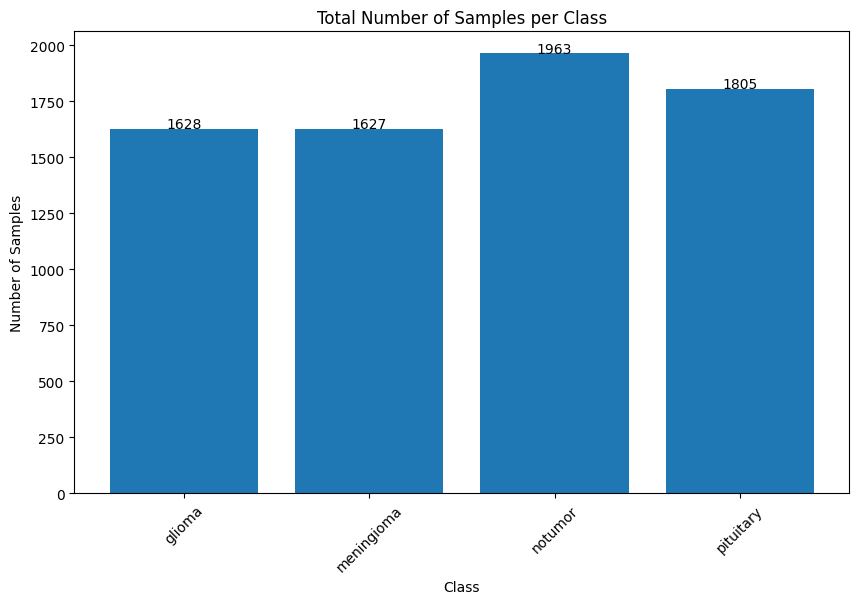

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Fungsi untuk membagi dataset menjadi subset per kelas
def split_by_class(dataset, class_names):
    class_datasets = {class_name: 0 for class_name in class_names}

    for images, labels in dataset:
        for i in range(len(images)):
            class_name = class_names[tf.argmax(labels[i])]
            class_datasets[class_name] += 1

    return class_datasets

# Membagi dataset train, validation, dan test berdasarkan kelas
train_class_counts = split_by_class(train_data, class_names)
val_class_counts = split_by_class(val_data, class_names)
test_class_counts = split_by_class(test_data, class_names)

# Menggabungkan jumlah sampel dari train, validation, dan test
total_class_counts = {class_name: train_class_counts[class_name] + val_class_counts[class_name] + test_class_counts[class_name] for class_name in class_names}

# Menampilkan jumlah sampel per kelas
plt.figure(figsize=(10, 6))
plt.bar(total_class_counts.keys(), total_class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Total Number of Samples per Class')
plt.xticks(rotation=45)

# Menambahkan jumlah sampel di atas setiap batang
for i, (class_name, count) in enumerate(total_class_counts.items()):
    plt.text(i, count + 2, str(count), ha='center')

plt.show()


# Define the callbacks

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model2.weights.h5',
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          mode='max')
lr_scheduler = LearningRateScheduler(lambda epoch: INIT_LR * pow(decay_rate, floor(epoch / decay_step)))

In [ ]:
!pip install pydot graphviz

# Creating the model (VGG19 + LSTM)

In [ ]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # Flatten output from LSTM
    x = Flatten()(x)

    # Output layer
    output = Dense(4, activation='softmax')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output)

    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

In [ ]:
model1 = Combined_model()

80134624/80134624 [==============================] - 1s 0us/step


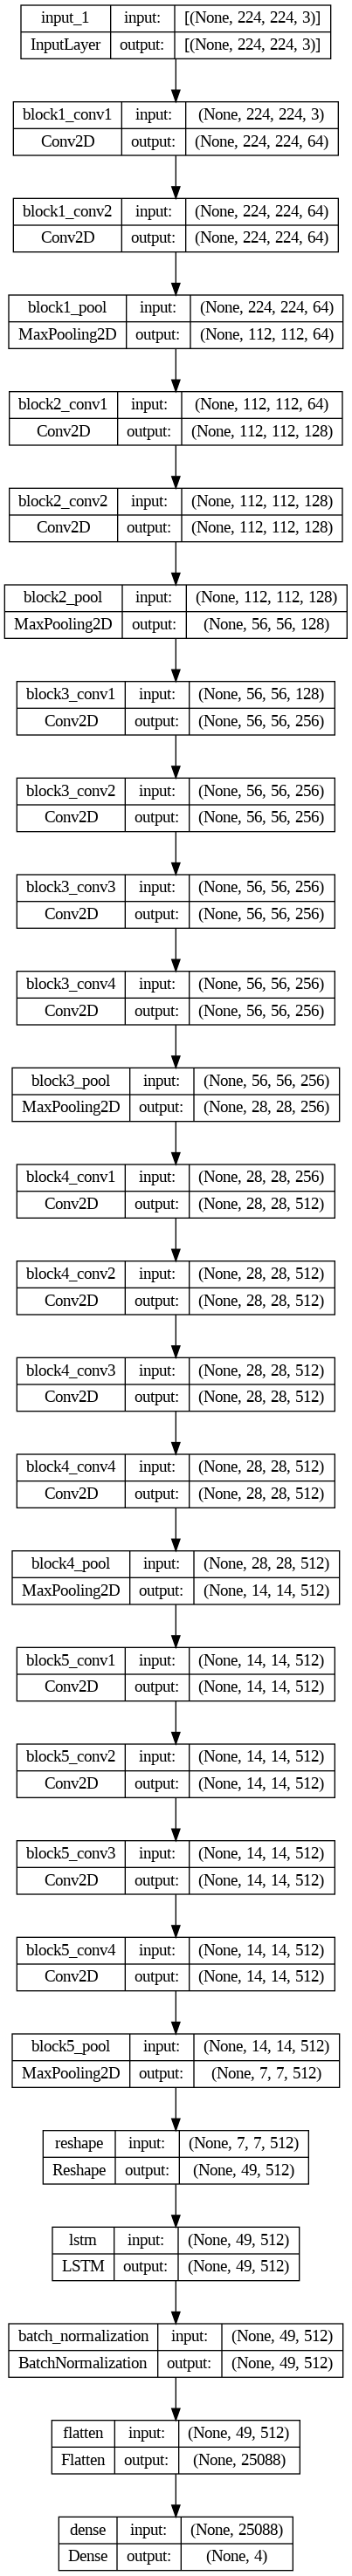

In [ ]:
from keras.utils import plot_model
# Plot the model architecture
plot_model(model1, to_file='model1_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
from IPython.display import Image
Image(filename='model1_architecture.png')

## Load and preprocess data

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Training the model

In [ ]:
history1 = model1.fit(train_dataset_augmented,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data=val_data,
                    callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.8090
Epoch 1: val_accuracy improved from -inf to 0.86111, saving model to best_model1.weights.h5
143/143 [==============================] - 58s 270ms/step - loss: 0.8331 - accuracy: 0.8090 - val_loss: 0.7300 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.8868
Epoch 2: val_accuracy improved from 0.86111 to 0.91233, saving model to best_model1.weights.h5
143/143 [==============================] - 49s 290ms/step - loss: 0.4972 - accuracy: 0.8868 - val_loss: 0.3824 - val_accuracy: 0.9123 - lr: 9.5000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.9103
Epoch 3: val_accuracy improved from 0.91233 to 0.91667, saving model to best_model1.weights.h5
143/143 [==============================] - 53s 309ms/step - loss: 0.4345 - accuracy: 0.9103 - val_loss: 0.4248 - val_accuracy: 0.916

## Classification Report

In [ ]:
# Fungsi untuk mengekstrak label dari dataset
def get_labels_from_dataset(dataset):
    labels = []
    for _, label in dataset.unbatch():
        labels.append(np.argmax(label.numpy()))
    return np.array(labels)

# Mendapatkan label sebenarnya dari test_data
true_labels = get_labels_from_dataset(test_data)

In [ ]:
from sklearn.metrics import classification_report

test_predictions = model1.predict(test_data)
pred_labels = np.argmax(test_predictions, axis=1)

report = classification_report(true_labels, pred_labels, target_names=test_data.class_names)

print(report)

41/41 [==============================] - 13s 305ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.93      0.97      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



## Confusion Matrix

41/41 [==============================] - 7s 162ms/step


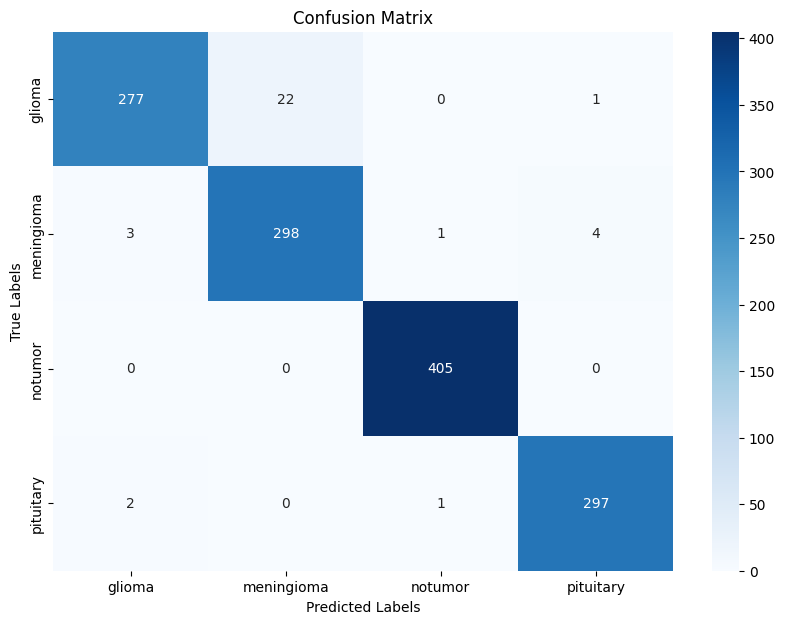

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set using the trained VGG19 + LSTM
test_predictions = model1.predict(test_data)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Loss Graph

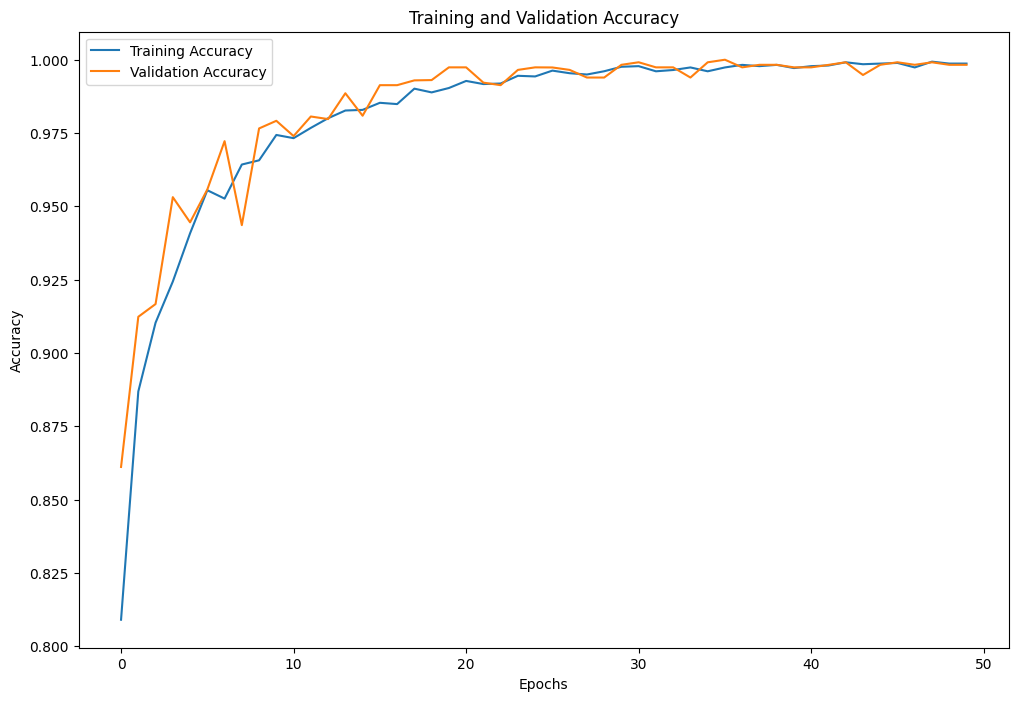

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(history1.history['loss'])

[0.8330563902854919, 0.4972470998764038, 0.43449681997299194, 0.3460657298564911, 0.24439774453639984, 0.20059658586978912, 0.1931809037923813, 0.1329052746295929, 0.13910777866840363, 0.11858174949884415, 0.10014478117227554, 0.09804157167673111, 0.07018974423408508, 0.08060755580663681, 0.0675555095076561, 0.056157469749450684, 0.04676802083849907, 0.03473871201276779, 0.04279770702123642, 0.040473103523254395, 0.023681670427322388, 0.025777490809559822, 0.028839249163866043, 0.01676732860505581, 0.02141975238919258, 0.014234477654099464, 0.017313269898295403, 0.016481230035424232, 0.012197045609354973, 0.011608858592808247, 0.008539828471839428, 0.013819118961691856, 0.01007530651986599, 0.010408594273030758, 0.00932648591697216, 0.008587125688791275, 0.007126390002667904, 0.007765722926706076, 0.005486376117914915, 0.013883143663406372, 0.005932018160820007, 0.0050454288721084595, 0.008417816832661629, 0.004614873323589563, 0.0076374574564397335, 0.004800103604793549, 0.01000758167

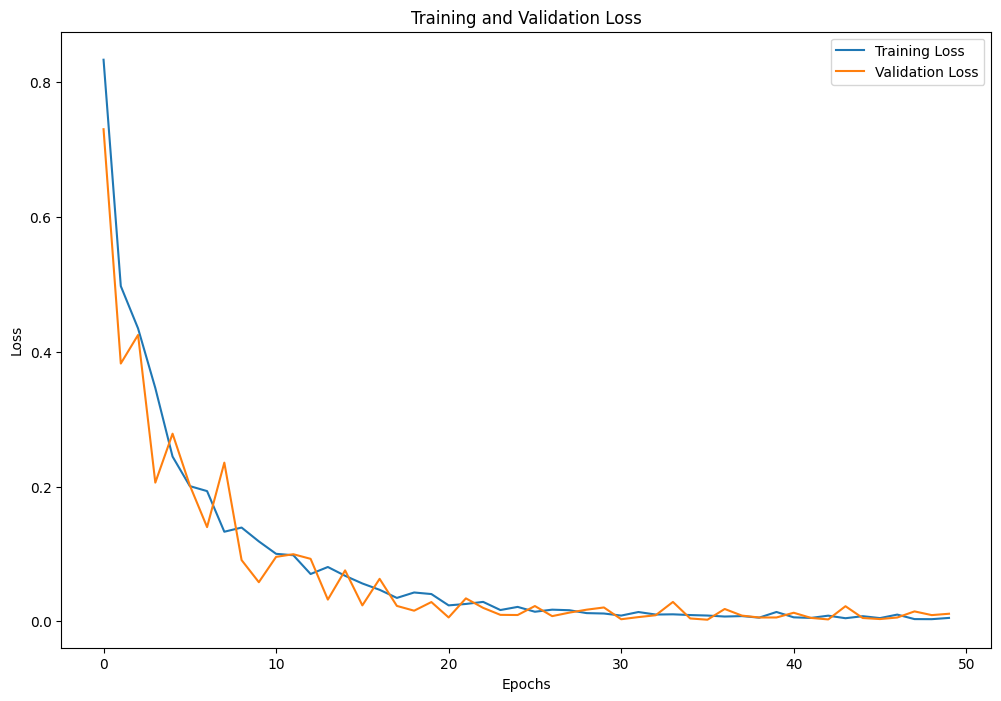

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#pip install pandas openpyxl

In [ ]:
import pandas as pd

In [ ]:
train_loss = history1.history['loss']
train_acc = history1.history['accuracy']
val_loss = history1.history['val_loss']
val_acc = history1.history['val_accuracy']

# Membuat DataFrame
epoch_model1 = pd.DataFrame({'train_loss': train_loss,
                   'train_acc': train_acc,
                   'val_loss': val_loss,
                   'val_acc': val_acc})

# Menampilkan DataFrame
print("DataFrame:")
print(epoch_model1 )

# Menyimpan DataFrame ke dalam file Excel
excel_file = 'history1_summary.xlsx'  # Nama file Excel yang akan disimpan
epoch_model1.to_excel(excel_file, index=False)  # Menyimpan DataFrame ke Excel tanpa indeks

DataFrame:
    train_loss  train_acc  val_loss   val_acc
0     0.833056   0.809003  0.730000  0.861111
1     0.497247   0.886842  0.382420  0.912326
2     0.434497   0.910307  0.424829  0.916667
3     0.346066   0.924342  0.205772  0.953125
4     0.244398   0.940789  0.278353  0.944542
5     0.200597   0.955482  0.201676  0.955729
6     0.193181   0.952632  0.139751  0.972222
7     0.132905   0.964254  0.235392  0.943576
8     0.139108   0.965691  0.090885  0.976562
9     0.118582   0.974342  0.058057  0.979167
10    0.100145   0.973246  0.095639  0.973958
11    0.098042   0.976754  0.099546  0.980634
12    0.070190   0.980044  0.092706  0.979753
13    0.080608   0.982675  0.032249  0.988556
14    0.067556   0.982895  0.075591  0.980903
15    0.056157   0.985307  0.023677  0.991319
16    0.046768   0.984868  0.063049  0.991319
17    0.034739   0.990132  0.022884  0.992958
18    0.042798   0.988855  0.015789  0.993056
19    0.040473   0.990351  0.028605  0.997396
20    0.023682   0.9927

# Creating the model (MobileNetV2)

In [ ]:
base_model2 = MobileNetV2(include_top= False, weights= "imagenet", input_shape=(224, 224, 3), pooling= 'max')
# Freeze all layers except the last 10 for fine-tuning
for layer in base_model2.layers[:-10]:
  layer.trainable = False

model2 = Sequential([
    base_model2,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016),
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006),
          activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(4, activation= 'softmax')
])

model2.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model2.summary()
# Print all layers of the base model (MobileNetV2)
print("All layers in the base model (MobileNetV2):")
for i, layer in enumerate(base_model2.layers):
    print(f"Layer {i+1}: {layer.name} ({layer.__class__.__name__}): {layer.output_shape}")

# Print the last 10 layers of the combined model
print("\nLast 10 layers of the combined model:")
for i, layer in enumerate(model2.layers[-10:]):
    print(f"Layer {i+1}: {layer.name} ({layer.__class__.__name__}): {layer.output_shape}")

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                           

## Training the model

In [ ]:
history2 = model2.fit(train_dataset_augmented,
                    epochs=45,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data=val_data,
                    callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/45
143/143 [==============================] - ETA: 0s - loss: 6.9036 - accuracy: 0.7552
Epoch 1: val_accuracy improved from -inf to 0.43316, saving model to best_model2.weights.h5
143/143 [==============================] - 47s 172ms/step - loss: 6.9036 - accuracy: 0.7552 - val_loss: 6.8510 - val_accuracy: 0.4332 - lr: 0.0010
Epoch 2/45
143/143 [==============================] - ETA: 0s - loss: 4.5993 - accuracy: 0.8388
Epoch 2: val_accuracy improved from 0.43316 to 0.45486, saving model to best_model2.weights.h5
143/143 [==============================] - 34s 177ms/step - loss: 4.5993 - accuracy: 0.8388 - val_loss: 4.8501 - val_accuracy: 0.4549 - lr: 9.5000e-04
Epoch 3/45
143/143 [==============================] - ETA: 0s - loss: 3.2436 - accuracy: 0.8621
Epoch 3: val_accuracy improved from 0.45486 to 0.46094, saving model to best_model2.weights.h5
143/143 [==============================] - 35s 172ms/step - loss: 3.2436 - accuracy: 0.8621 - val_loss: 3.8272 - val_accuracy: 0.460

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

test_predictions2 = model2.predict(test_data)
pred_labels2 = np.argmax(test_predictions2, axis=1)

report = classification_report(true_labels, pred_labels2, target_names=test_data.class_names)

print(report)

41/41 [==============================] - 6s 95ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91       300
  meningioma       0.86      0.81      0.84       306
     notumor       0.93      1.00      0.96       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.93      0.92      1311



## Confussion Matrix

41/41 [==============================] - 2s 53ms/step


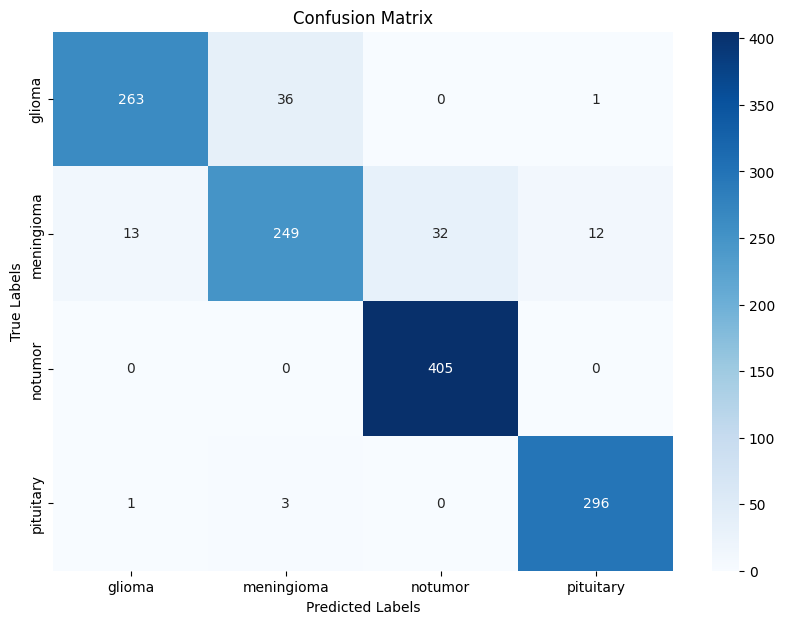

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the labels of the test set using the trained MobileNetV2
test_predictions2 = model2.predict(test_data)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels2)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Loss Graph

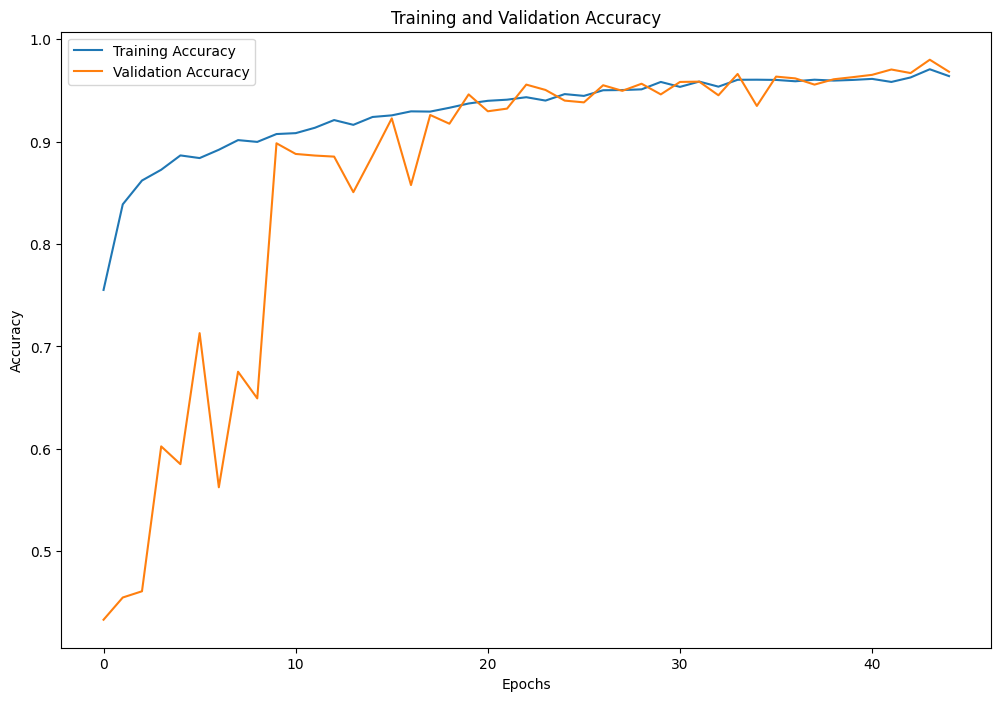

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

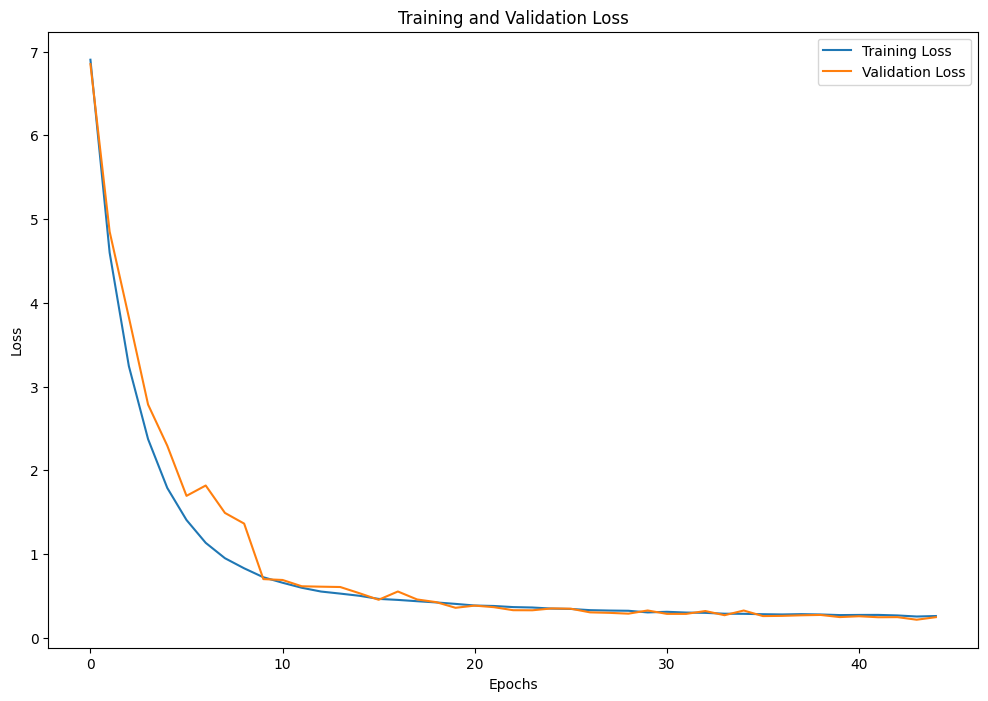

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']

# Membuat DataFrame
epoch_model2 = pd.DataFrame({'train_loss': train_loss,
                   'train_acc': train_acc,
                   'val_loss': val_loss,
                   'val_acc': val_acc})

# Menampilkan DataFrame
print("DataFrame:")
print(epoch_model2 )

# Menyimpan DataFrame ke dalam file Excel
excel_file = 'history2_summary.xlsx'  # Nama file Excel yang akan disimpan
epoch_model2.to_excel(excel_file, index=False)  # Menyimpan DataFrame ke Excel tanpa indeks

DataFrame:
    train_loss  train_acc  val_loss   val_acc
0     6.903631   0.755245  6.851010  0.433160
1     4.599271   0.838816  4.850111  0.454861
2     3.243607   0.862061  3.827217  0.460938
3     2.371276   0.872588  2.784364  0.602431
4     1.787901   0.886582  2.292569  0.585069
5     1.405221   0.883991  1.693628  0.713028
6     1.132236   0.892105  1.817244  0.562500
7     0.948810   0.901535  1.489895  0.675347
8     0.828151   0.899781  1.362254  0.649306
9     0.721341   0.907456  0.699049  0.898438
10    0.655577   0.908333  0.688783  0.888021
11    0.595623   0.913597  0.613451  0.886444
12    0.550622   0.921110  0.608675  0.885417
13    0.525992   0.916447  0.604700  0.850694
14    0.499891   0.924123  0.530604  0.886285
15    0.462726   0.925699  0.452300  0.922743
16    0.450688   0.929605  0.551129  0.857639
17    0.435008   0.929386  0.456048  0.926056
18    0.420419   0.933114  0.423795  0.917535
19    0.403149   0.937281  0.356506  0.946181
20    0.383711   0.9399

# Creating the model (Xception)

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax

base_model3 = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= (224, 224, 3), pooling= 'max')

for layer in base_model3.layers:
     layer.trainable = False

model3 = Sequential([
    base_model3,
    Flatten(),
    Dropout(rate= 0.2),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.2),
    Dense(4, activation= 'softmax')
])

model3.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 2627

## Training the model

In [ ]:
history3 = model3.fit(train_dataset_augmented,
                    epochs=25,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data=val_data,
                    callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/25
143/143 [==============================] - ETA: 0s - loss: 4.4372 - accuracy: 0.4406
Epoch 1: val_accuracy improved from -inf to 0.57639, saving model to best_model2.weights.h5
143/143 [==============================] - 52s 243ms/step - loss: 4.4372 - accuracy: 0.4406 - val_loss: 1.0413 - val_accuracy: 0.5764 - lr: 0.0010
Epoch 2/25
143/143 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.4691
Epoch 2: val_accuracy improved from 0.57639 to 0.58507, saving model to best_model2.weights.h5
143/143 [==============================] - 41s 227ms/step - loss: 1.2968 - accuracy: 0.4691 - val_loss: 1.0496 - val_accuracy: 0.5851 - lr: 9.5000e-04
Epoch 3/25
143/143 [==============================] - ETA: 0s - loss: 1.1602 - accuracy: 0.5156
Epoch 3: val_accuracy improved from 0.58507 to 0.62587, saving model to best_model2.weights.h5
143/143 [==============================] - 41s 229ms/step - loss: 1.1602 - accuracy: 0.5156 - val_loss: 0.9379 - val_accuracy: 0.625

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

test_predictions3 = model3.predict(test_data)
pred_labels3 = np.argmax(test_predictions3, axis=1)

report = classification_report(true_labels, pred_labels3, target_names=test_data.class_names)

print(report)

41/41 [==============================] - 9s 199ms/step
              precision    recall  f1-score   support

      glioma       0.72      0.60      0.65       300
  meningioma       0.61      0.46      0.52       306
     notumor       0.87      0.88      0.87       405
   pituitary       0.68      0.96      0.79       300

    accuracy                           0.73      1311
   macro avg       0.72      0.72      0.71      1311
weighted avg       0.73      0.73      0.72      1311



## Confussion Matrix

41/41 [==============================] - 5s 126ms/step


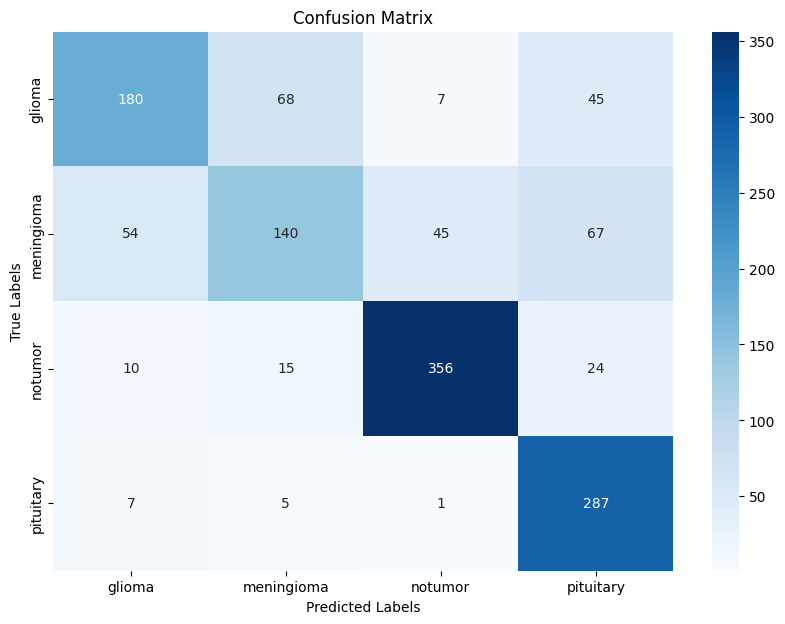

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the labels of the test set using the trained MobileNetV2
test_predictions3 = model3.predict(test_data)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels3)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Loss Graph

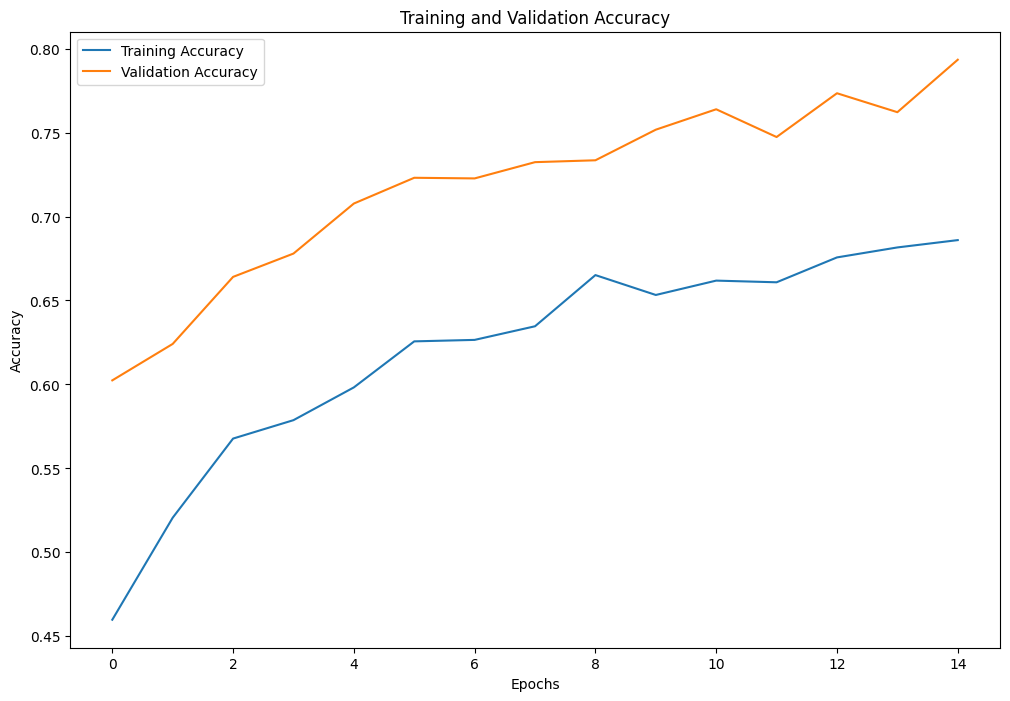

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

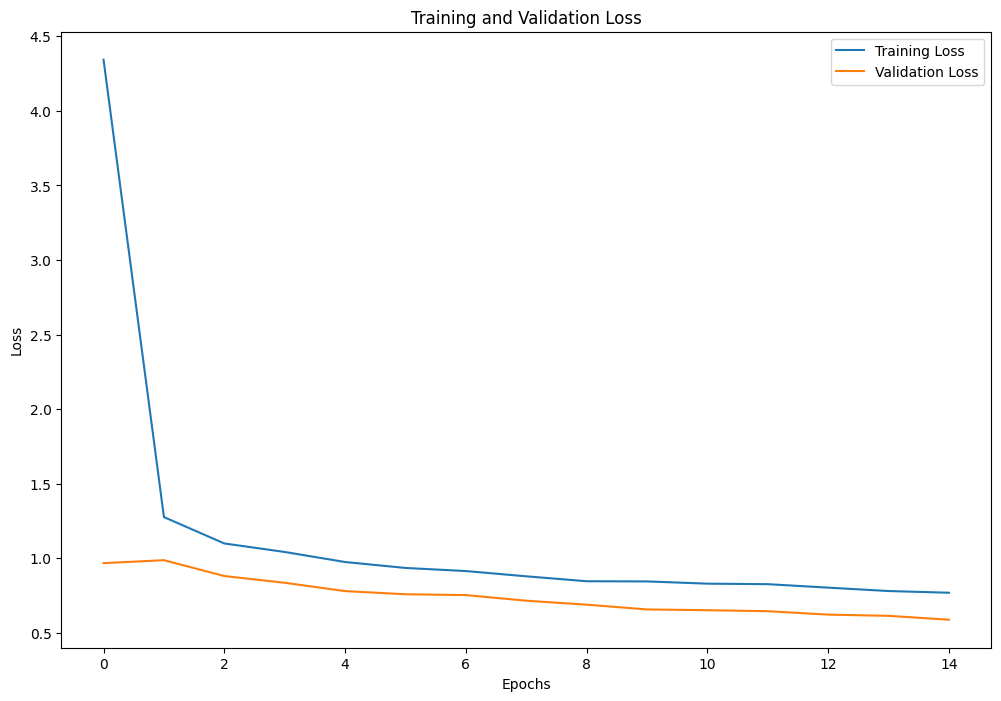

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perbandingan

In [ ]:
plt.figure(figsize=(12, 8))

# Plot history1
plt.plot(history1['accuracy'], label='Training Accuracy (History 1)', linestyle='-', color='b')
plt.plot(history1['val_accuracy'], label='Validation Accuracy (History 1)', linestyle='--', color='b')

# Plot history2
plt.plot(history2['accuracy'], label='Training Accuracy (History 2)', linestyle='-', color='g')
plt.plot(history2['val_accuracy'], label='Validation Accuracy (History 2)', linestyle='--', color='g')

# Plot history3
plt.plot(history3['accuracy'], label='Training Accuracy (History 3)', linestyle='-', color='r')
plt.plot(history3['val_accuracy'], label='Validation Accuracy (History 3)', linestyle='--', color='r')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Extracting features

In [ ]:
def extract_features(data_generator, model):
    features = []
    labels = []
    for images, batch_labels in data_generator:
        batch_features = model.predict(images)
        features.append(batch_features)
        labels.append(batch_labels.numpy())  # Convert labels to numpy arrays

    # Concatenate all the features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_data, model)
test_features, test_labels = extract_features(test_data, model)

In [ ]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Training SVM on extracted features

In [ ]:
scaler = StandardScaler()
num_samples, num_features = train_features.shape
pca_components = min(num_samples, num_features, 64)  # Adjust the number of PCA components as needed
pca = PCA(n_components=pca_components)
svm_model = SVC(kernel="linear", C=1.0, probability=True)

In [ ]:
train_features_scaled = scaler.fit_transform(train_features)
train_features_pca = pca.fit_transform(train_features_scaled)

In [ ]:
svm_model.fit(train_features_pca, train_labels)

In [ ]:
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
accuracy = svm_model.score(test_features_pca, test_labels)
print(f'SVM Accuracy: {accuracy}')